<a href="https://colab.research.google.com/github/NirranjanOfficial/grinding-lab/blob/main/Fashion_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook i hav etrained an CNN model to identify the **MNIST fashion dataset** and to return what kind of object it is.
In the official org they used FCNN in order to train, yet i used the same concept i used in the digit recognition and continued to make this!

Resource of official docx - ' https://docs.pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html '

In [1]:
import torch   #Building the nerual network
import torch.nn as nn  #Building the nerual network
import torch.optim as optim  #used in order to get the optimisers
from torchvision import datasets, transforms  # to import the dataset directly into the notebook
from torch.utils.data import DataLoader   # to batch and shuffle data
import matplotlib.pyplot as plt  # to visvalise the data
import seaborn as sns  # to visvalise the data
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In general we need the mean and the STD in order to optimise the computation but we won't know the values always so we need to determine those!


In [2]:
# Only ToTensor – no Normalize yet
transform = transforms.ToTensor()

dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=1000, shuffle=False)

mean = 0.0
std = 0.0
total_images = 0

for images, _ in loader:
    # images shape: [B, 1, 28, 28]
    batch_samples = images.size(0)
    images = images.view(batch_samples, -1)  # Flatten to [B, 784]

    mean += images.mean(1).sum()
    std += images.std(1).sum()
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f"Fashion MNIST Mean: {mean:.4f}")
print(f"Fashion MNIST Std: {std:.4f}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 176kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.12MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.0MB/s]


Fashion MNIST Mean: 0.2860
Fashion MNIST Std: 0.3205


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,),(std,))  #Standard for MNIST
])

In [4]:
train_dataset = datasets.FashionMNIST(root='/.data', train=True, transform=transform, download=True)  # loads the 60000 train images
test_dataset = datasets.FashionMNIST(root='/.data', train=False, transform=transform, download=True)   #loads the 10000 test images

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.80MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.28MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.1MB/s]


In [5]:
training_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

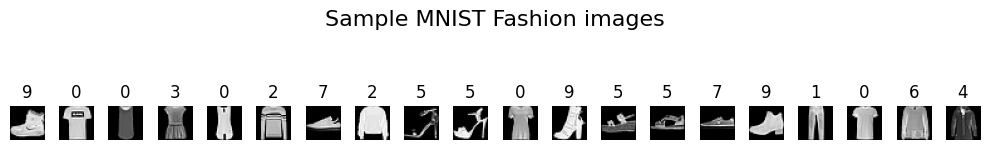

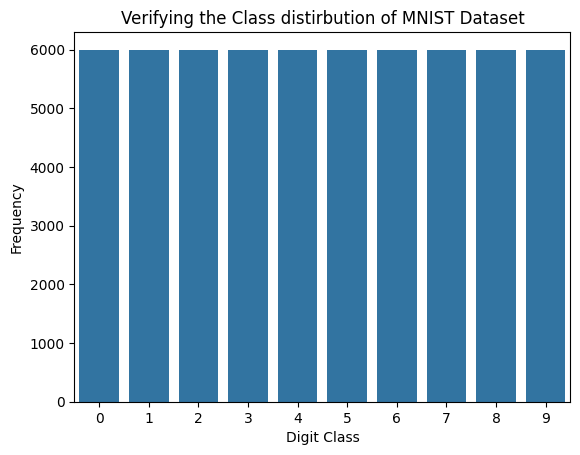

In [6]:
'''Here we are using EDA ie we are using Plot to see what kind of
data we are working on '''

#Looking the type of data we are working on
def show_samples(dataset,n=20):
  plt.figure(figsize=(10,2))
  for i in range(n):
    image,label = dataset[i]
    plt.subplot(1,n,i+1)
    plt.imshow(image.squeeze(),cmap='gray')
    plt.title(label)
    plt.axis('off')
  plt.suptitle("Sample MNIST Fashion images", fontsize=16)
  plt.tight_layout()
  plt.show()
show_samples(train_dataset)

print()

#Checking the frequency of each classes
labels=[label for _, label in train_dataset]
sns.countplot(x=labels)
plt.title("Verifying the Class distirbution of MNIST Dataset")
plt.xlabel("Digit Class")
plt.ylabel("Frequency")
plt.show()

In [7]:
class Model(torch.nn.Module):
  def __init__(self):
     super(Model,self).__init__()
     self.conv1 = torch.nn.Conv2d(1,16,3, padding=1) # 1ip channel,16 filters, filter size 3x3...padding is added to make the output size remain the same
     self.pool = torch.nn.MaxPool2d(2,2) #it reduces the spacial features ie here it halves the height and width in the input
     self.conv2 = torch.nn.Conv2d(16,32,3, padding =1) #16 op from past, 32 new features
     self.fc1 = torch.nn.Linear(32*7*7,128)
     self.fc2 = torch.nn.Linear(128,10)

  def forward(self,x):
    x = self.pool(torch.relu(self.conv1(x)))
    x = self.pool(torch.relu(self.conv2(x)))
    x = x.view(-1,32*7*7)
    x = torch.relu(self.fc1(x))
    return self.fc2(x)
model = Model()

In [8]:
#Main part is loss and optimizer
criterion = torch.nn.CrossEntropyLoss()  #crossEntropy is an go to choice for an multi class classification
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [9]:
#training loop:
epochs = 5
train_loss = []
for epoch in range(epochs):
  model.train()  #train mode
  running_loss = 0.0
  for images,labels in training_loader:
    optimizer.zero_grad()  #to reset the gradients from each step
    outputs = model(images)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()  #updates model weights
    running_loss +=loss.item()
  avg_loss = running_loss/len(training_loader)
  train_loss.append(avg_loss)
  print(f"Epoch [{epoch+1}/{epochs}], Loss:{avg_loss:.4f}")

Epoch [1/5], Loss:0.4474
Epoch [2/5], Loss:0.2906
Epoch [3/5], Loss:0.2483
Epoch [4/5], Loss:0.2165
Epoch [5/5], Loss:0.1947


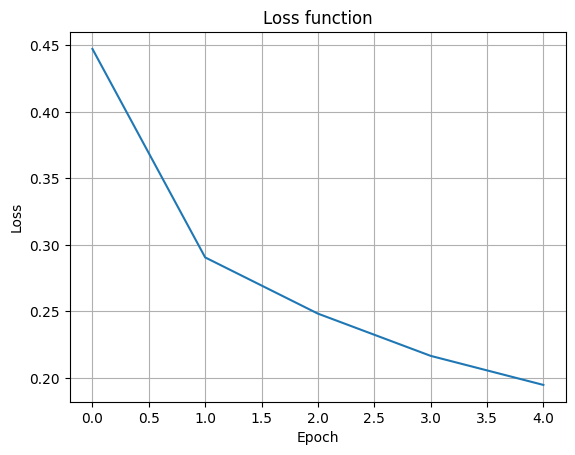

In [10]:
#lets plot the loss func out there
plt.plot(train_loss)
plt.title("Loss function")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [11]:
# now lets test how well our data will work by evaluating
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():  #to prevent pytorch from tracking gradient
  for images,labels in test_loader:
    output = model(images) # to check every image
    _, predicted = torch.max(output,1)  #exteact the highest classes with image
    all_preds.extend(predicted.numpy())
    all_labels.extend(labels.numpy())

#Accuracy and classification
print("\n Classification Report:")
print(classification_report(all_labels,all_preds))


 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.86      0.87      1000
           3       0.91      0.92      0.92      1000
           4       0.84      0.89      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.72      0.78      0.75      1000
           7       0.97      0.97      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



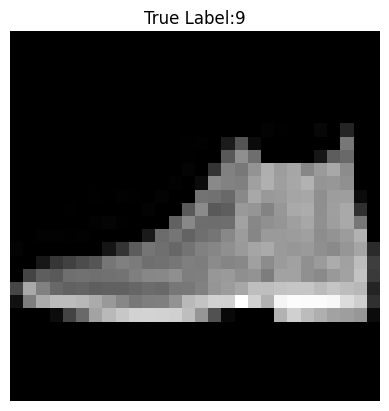

Predicted Class:9


In [12]:
#Lets check it out we an real time example fro mthe dataset

sample_img , sample_label = test_dataset[0]
plt.imshow(sample_img.squeeze(),cmap='gray')
plt.title(f"True Label:{sample_label}")
plt.axis('off')
plt.show()

sample_tensor = sample_img.unsqueeze(0)  # to remove from the batch
with torch.no_grad():
  output = model(sample_tensor)
  predicted_class = torch.argmax(output).item()
  print(f"Predicted Class:{predicted_class}")

Working good need to try out with different optimizers and differnt lr,etc.,
